# Imports

In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Input, Reshape, ReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout
from tensorflow.keras.layers import Dropout, Dense, StringLookup

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Hyperparameters

In [2]:
CHARS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
VOCAB_LEN = 11
WIDTH = 200
HEIGHT = 50
TRAIN_SIZE = 0.85
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 100

# Utility Functions

In [3]:
# Mapping characters to integers
char_to_num = StringLookup(vocabulary=CHARS)

# Mapping integers back to original characters
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
)

In [4]:
def read_dataset(directory):
    data_dir = Path(directory)
    images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
    labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
    return images, labels

In [5]:
def split_data(images, labels, train_size):
    # 1. Get the total size of the dataset
    size = len(images)

    # 2. Make an indices array and shuffle it
    indices = np.arange(size)
    np.random.shuffle(indices)

    # 3. Get the size of training samples
    train_samples = int(size * train_size)

    # 4. Split data into training and validation sets
    x_train = images[indices[:train_samples]]
    y_train = labels[indices[:train_samples]]

    x_val = images[indices[train_samples:]]
    y_val = labels[indices[train_samples:]]

    return x_train, y_train, x_val, y_val

In [6]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to RGB
    img = tf.io.decode_png(img, channels=3)

    # Custom transformations
    img = tf.image.random_jpeg_quality(img, 40, 80)

    img = tf.image.rgb_to_grayscale(img)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [HEIGHT, WIDTH])

    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])

    # 6. Map the characters in label to numbers
    label = char_to_num(
        tf.strings.unicode_split(label, input_encoding="UTF-8")
    )
    
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [7]:
def get_generators(dataset, batch_size):
    x_train, y_train, x_val, y_val = dataset

    # Train
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

    train_dataset = (
        train_dataset.map(
            encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # Validation
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    val_dataset = (
        val_dataset.map(
            encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    return train_dataset, val_dataset

In [8]:
def plot_loss(history, title):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.title(title)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.grid()
    plt.show()

In [9]:
def plot_result(batch, pred_texts=None):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    batch_size = len(batch_images)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(batch_size):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T

        if pred_texts:
            title = f"Pred: {pred_texts[i]}"
        else:
            title = f"True: {orig_texts[i]}"
        
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
    plt.show()

In [10]:
# Get the prediction model by extracting layers till the output layer
def get_predictor_models(model_path):
    model = load_model(
        model_path,
        custom_objects={'CTCLayer': CTCLayer}
    )

    predictor_model = Model(
        model.get_layer(name="image").input,
        model.get_layer(name="Dense2").output
    )

    return predictor_model

In [11]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred, max_length):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = K.ctc_decode(
        pred,
        input_length=input_len,
        greedy=True
    )[0][0][:, :max_length]

    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        res = res.replace('[UNK]', 'x')
        output_text.append(res)
    return output_text

# Model Structure

In [12]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [13]:
def build_model(input_shape, vocab_len):
    # Inputs
    input_img = Input(
        shape=input_shape,
        name="image",
        dtype="float32",
    )
    input_label = Input(
        shape=(None,),
        name="label",
        dtype="float32",
    )

    # Conv Block 1
    x = Conv2D(
        filters=32,
        kernel_size=(3, 3),
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = BatchNormalization(name="BN1")(x)
    x = ReLU(name="ReLU1")(x)
    x = MaxPool2D(
        pool_size=(2, 2),
        name="Pool1"
    )(x)
    x = Dropout(0.25)(x)

    # Conv Block 2
    x = Conv2D(
        filters=64,
        kernel_size=(3, 3),
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="ReLU2")(x)
    x = MaxPool2D(
        pool_size=(2, 2),
        name="Pool2"
    )(x)
    x = Dropout(0.25)(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((input_shape[0] // 4), (input_shape[1] // 4) * 64)

    x = Reshape(target_shape=new_shape, name="Reshape")(x)
    x = Dense(64, activation="relu", name="Dense1")(x)
    x = Dropout(0.25, name="Dropout1")(x)

    # RNNs
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = Dense(
        vocab_len + 1,
        activation="softmax",
        name="Dense2",
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="CTC_Loss")(input_label, x)

    # Define the model
    model = Model(
        inputs=[input_img, input_label],
        outputs=output,
        name="OCR_Model",
    )
    return model

In [14]:
model = build_model(
    input_shape=(WIDTH, HEIGHT, 1),
    vocab_len=VOCAB_LEN,
)
model.summary()

Model: "OCR_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 BN1 (BatchNormalization)       (None, 200, 50, 32)  128         ['Conv1[0][0]']                  
                                                                                                  
 ReLU1 (ReLU)                   (None, 200, 50, 32)  0           ['BN1[0][0]']            

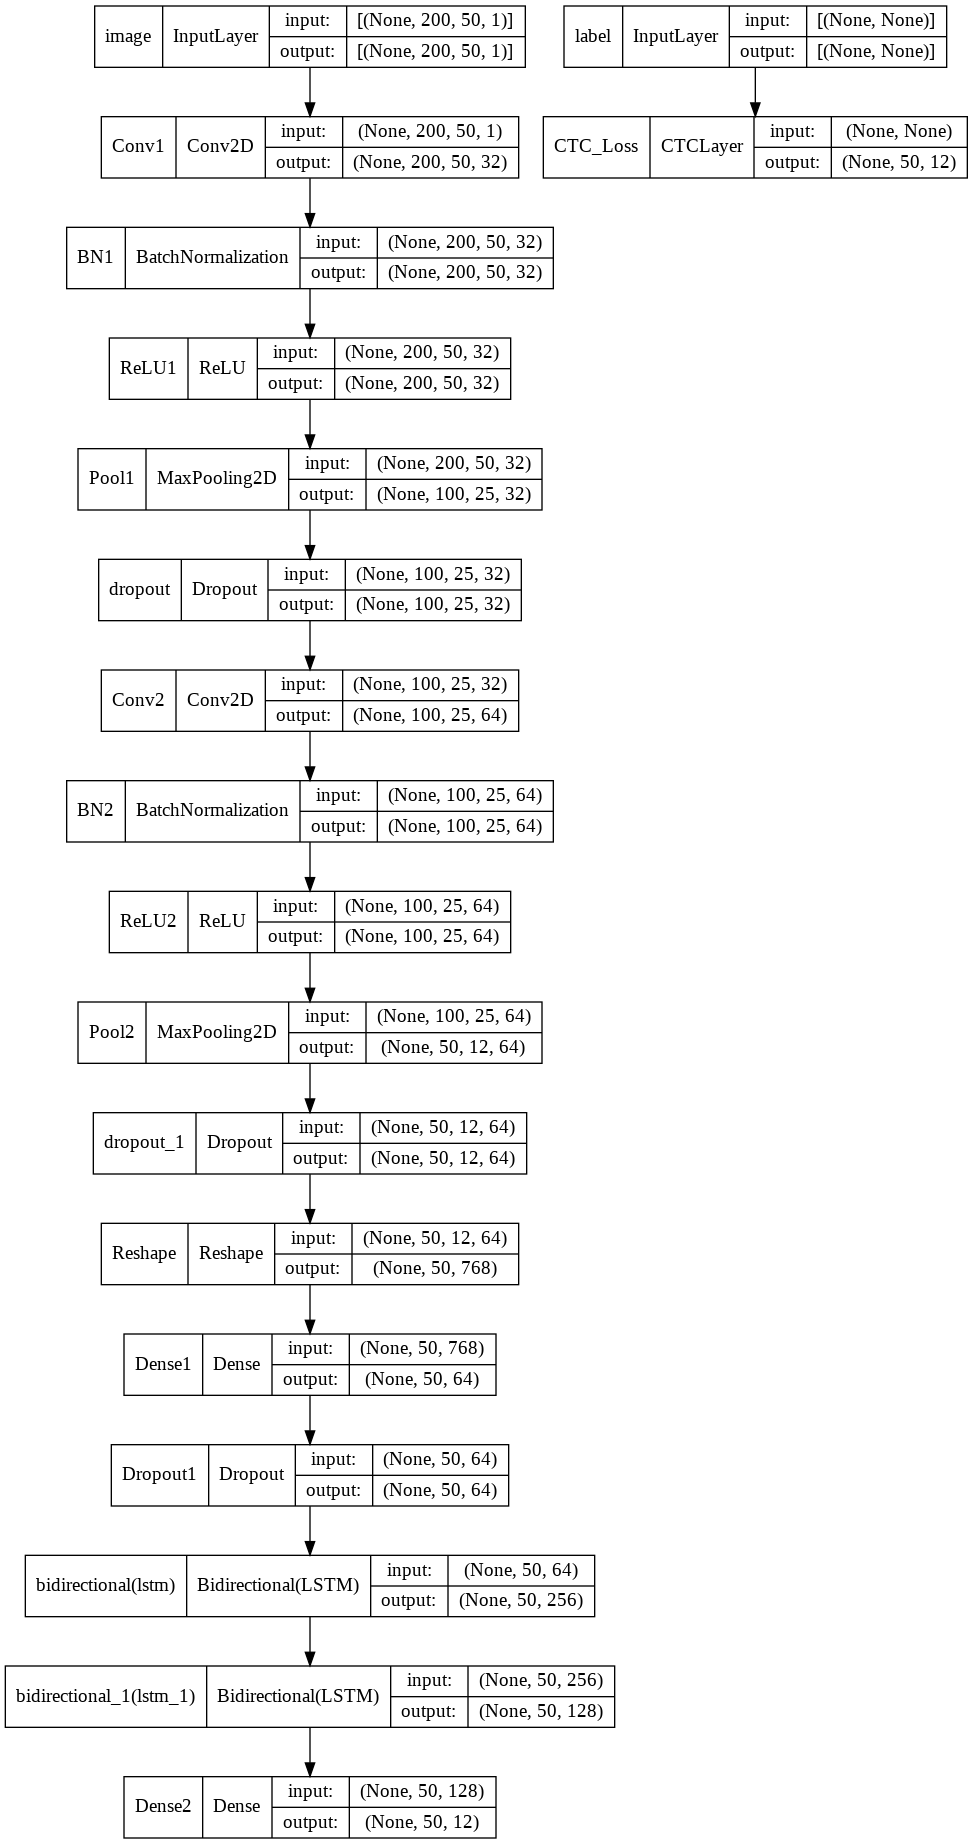

In [15]:
plot_model(
    model,
    to_file="OCR_Model.png",
    show_shapes=True,
    show_layer_names=True
)

# Dataset

In [16]:
!gdown --id 1vJ8HUbgZvIlP867jxbeMhtXI5HAGSnbu
!unzip -qq -n Dataset.zip
!rm Dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1vJ8HUbgZvIlP867jxbeMhtXI5HAGSnbu
To: /content/Dataset.zip
100% 10.4M/10.4M [00:00<00:00, 103MB/s]


In [17]:
credit_path = 'Dataset/Credit'
national_path = 'Dataset/National'

credit_ds = read_dataset(credit_path)
national_ds = read_dataset(national_path)

In [18]:
cred_x_train, cred_y_train, cred_x_val, cred_y_val = split_data(
    images=np.array(credit_ds[0]),
    labels=np.array(credit_ds[1]),
    train_size=TRAIN_SIZE,
)

print('cred_x_train: ', cred_x_train.shape)
print('cred_y_train: ', cred_y_train.shape)
print('cred_x_val: ', cred_x_val.shape)
print('cred_y_val: ', cred_y_val.shape)

cred_x_train:  (850,)
cred_y_train:  (850,)
cred_x_val:  (150,)
cred_y_val:  (150,)


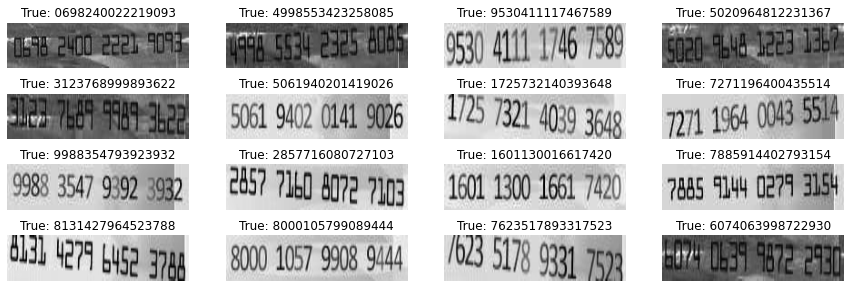

In [19]:
cred_train_dataset, cred_val_dataset = get_generators(
    (cred_x_train, cred_y_train, cred_x_val, cred_y_val),
    BATCH_SIZE,
)

for batch in cred_train_dataset.take(1):
    plot_result(batch, pred_texts=None)

In [20]:
nat_x_train, nat_y_train, nat_x_val, nat_y_val = split_data(
    images=np.array(national_ds[0]),
    labels=np.array(national_ds[1]),
    train_size=TRAIN_SIZE,
)

print('nat_x_train: ', nat_x_train.shape)
print('nat_y_train: ', nat_y_train.shape)
print('nat_x_val: ', nat_x_val.shape)
print('nat_y_val: ', nat_y_val.shape)

nat_x_train:  (850,)
nat_y_train:  (850,)
nat_x_val:  (150,)
nat_y_val:  (150,)


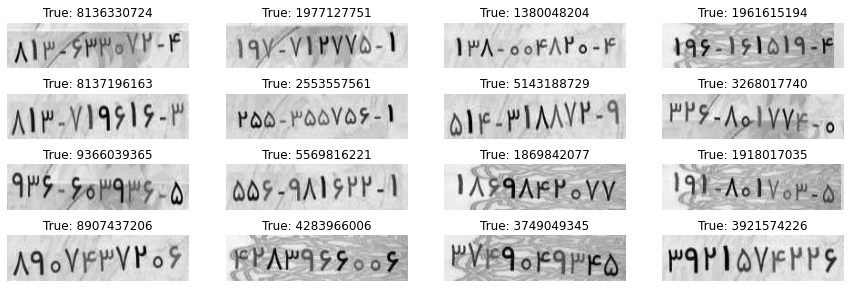

In [21]:
nat_train_dataset, nat_val_dataset = get_generators(
    (nat_x_train, nat_y_train, nat_x_val, nat_y_val),
    BATCH_SIZE,
)

for batch in nat_train_dataset.take(1):
    plot_result(batch, pred_texts=None)

# Train on credit cards

In [22]:
model = build_model(
    input_shape=(WIDTH, HEIGHT, 1),
    vocab_len=VOCAB_LEN,
)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))

model_checkpont = ModelCheckpoint(
    filepath='./checkpoints/credit_model.hdf5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
)

In [23]:
history = model.fit(
    cred_train_dataset,
    validation_data=cred_val_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpont],
)

Epoch 1/100
54/54 [==============================] - 42s 219ms/step - loss: 40.1784 - val_loss: 39.2719
Epoch 2/100
54/54 [==============================] - 7s 124ms/step - loss: 39.0720 - val_loss: 39.2519
Epoch 3/100
54/54 [==============================] - 6s 103ms/step - loss: 39.0479 - val_loss: 39.2448
Epoch 4/100
54/54 [==============================] - 5s 100ms/step - loss: 38.9606 - val_loss: 39.0552
Epoch 5/100
54/54 [==============================] - 5s 101ms/step - loss: 38.6827 - val_loss: 38.2814
Epoch 6/100
54/54 [==============================] - 5s 102ms/step - loss: 37.6229 - val_loss: 36.9468
Epoch 7/100
54/54 [==============================] - 5s 99ms/step - loss: 35.3706 - val_loss: 37.8942
Epoch 8/100
54/54 [==============================] - 5s 99ms/step - loss: 30.3421 - val_loss: 41.8443
Epoch 9/100
54/54 [==============================] - 6s 116ms/step - loss: 23.3443 - val_loss: 17.5505
Epoch 10/100
54/54 [==============================] - 5s 101ms/step - loss

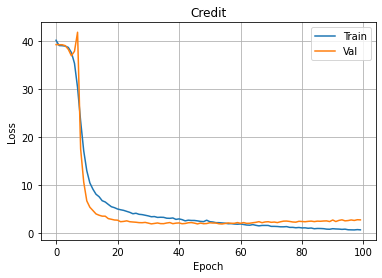

In [24]:
plot_loss(history, 'Credit')

# Train on national cards

In [25]:
model = build_model(
    input_shape=(WIDTH, HEIGHT, 1),
    vocab_len=VOCAB_LEN,
)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))

model_checkpont = ModelCheckpoint(
    filepath='./checkpoints/national_model.hdf5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
)

In [26]:
history = model.fit(
    nat_train_dataset,
    validation_data=nat_val_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpont],
)

Epoch 1/100
54/54 [==============================] - 15s 142ms/step - loss: 27.3011 - val_loss: 25.1028
Epoch 2/100
54/54 [==============================] - 5s 101ms/step - loss: 25.0382 - val_loss: 25.0445
Epoch 3/100
54/54 [==============================] - 6s 102ms/step - loss: 24.7668 - val_loss: 24.6963
Epoch 4/100
54/54 [==============================] - 6s 102ms/step - loss: 23.6208 - val_loss: 23.1536
Epoch 5/100
54/54 [==============================] - 5s 101ms/step - loss: 20.8275 - val_loss: 19.9978
Epoch 6/100
54/54 [==============================] - 5s 99ms/step - loss: 13.4289 - val_loss: 12.0690
Epoch 7/100
54/54 [==============================] - 5s 100ms/step - loss: 4.7505 - val_loss: 2.2269
Epoch 8/100
54/54 [==============================] - 5s 101ms/step - loss: 1.9048 - val_loss: 0.8416
Epoch 9/100
54/54 [==============================] - 5s 99ms/step - loss: 1.1406 - val_loss: 0.2418
Epoch 10/100
54/54 [==============================] - 5s 101ms/step - loss: 0.70

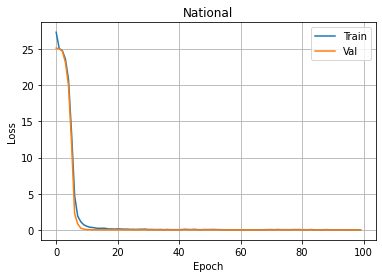

In [27]:
plot_loss(history, 'National')

# Evaluation on credit cards

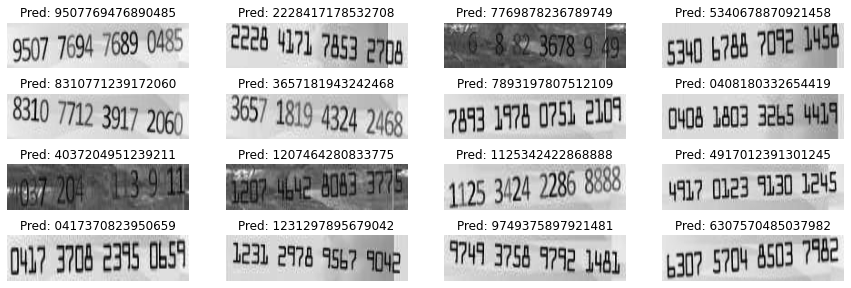

In [28]:
cred_model = get_predictor_models('./checkpoints/credit_model.hdf5')
max_length = 16

for batch in cred_val_dataset.take(1):
    preds = cred_model.predict(batch['image'])
    pred_texts = decode_batch_predictions(preds, max_length)
    plot_result(batch, pred_texts)
# for s in pred_texts:
#     print(f'{s}---{len(s)}')

# Evaluation on national cards

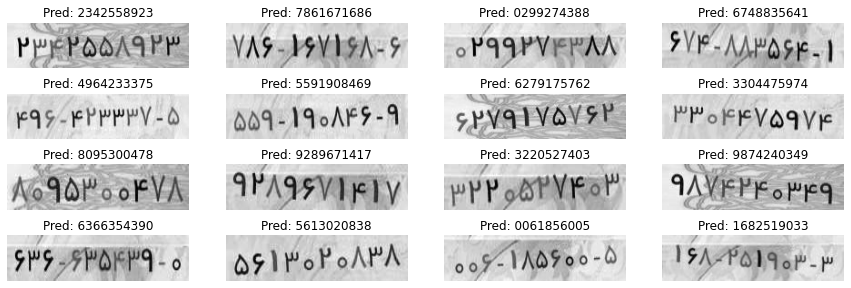

In [29]:
nat_model = get_predictor_models('./checkpoints/national_model.hdf5')
max_length = 10

for batch in nat_val_dataset.take(1):
    preds = nat_model.predict(batch['image'])
    pred_texts = decode_batch_predictions(preds, max_length)
    plot_result(batch, pred_texts)
# for s in pred_texts:
#     print(f'{s}---{len(s)}')